In [1]:
%autoreload 2
import numpy as np
import matplotlib.pyplot as pl
import sys
sys.path.append('../')

import rl.gridworld as gw

# Gridworld

$(n_x, n_y)$ dimensional gridworld with a single target field. The aim is to practice reinforcement learning techniques by training an agent to move to the (to him unknown) target state in as many steps as possible.

**Notation**: 
* $P^a$ state transition probablities for the action $a$
* $P^\pi$ state transition probablities for fixed policy $\pi$; defined by $P^\pi_{s,s'} = \sum_a \pi(a|s) P^a_{s,s'}$
* $R^a_s$ reward function for action $a$ when agent is in state $s$
* $R^\pi_s$ -> expected reward for fixed policy $\pi$
* $\gamma$ discount factor

When we leave out the policy index $\pi$ we refer to the respective quantities for some fixed Markov reward process. Note that our defition of the indices of $P$ is reverse from those of Silver

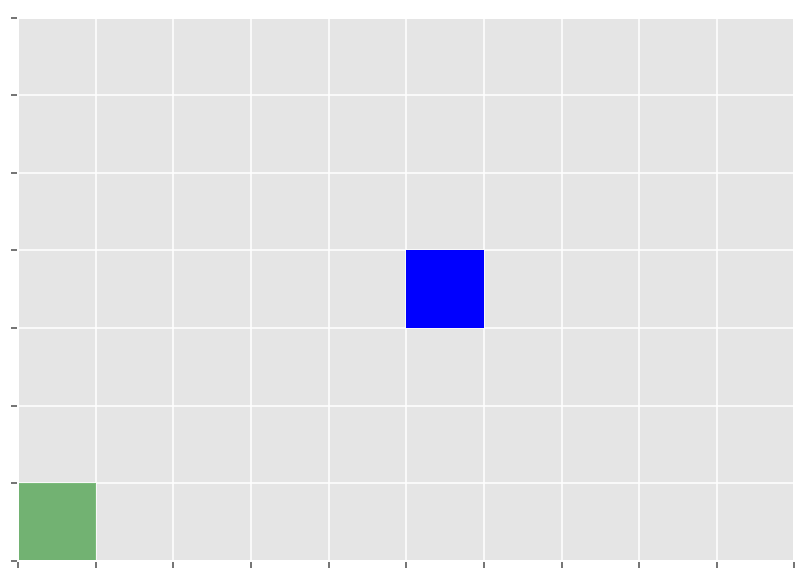

In [2]:
world = gw.Gridworld((10, 7))
world.render()

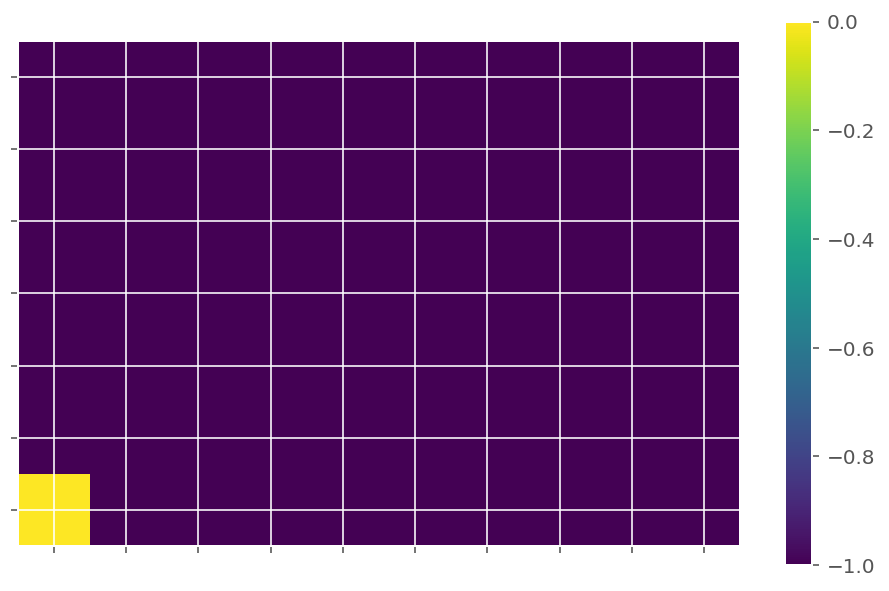

In [3]:
def imshow_world(world, img, ax=None, **kwargs):
    ax = gw._render_grid(world.gridsize)
    img = ax.imshow(img.reshape(world.gridsize).T[::-1, :], **kwargs)
    pl.colorbar(img)
    return ax

imshow_world(world, world.state_reward)

## Dynamic Programming

Since the statespace is rather small, we can get away without actually using RL, but using standard dynamic programming techniques.

### Value evaluation

For a time-homogenous MRP, the value function fulfills the _Belmann equation_

$$v = R + \gamma P v$$

By iterating this equation we can estimate the value function for a given MRP.

Goodness of iterative algorithm: 1.70709842067e-05


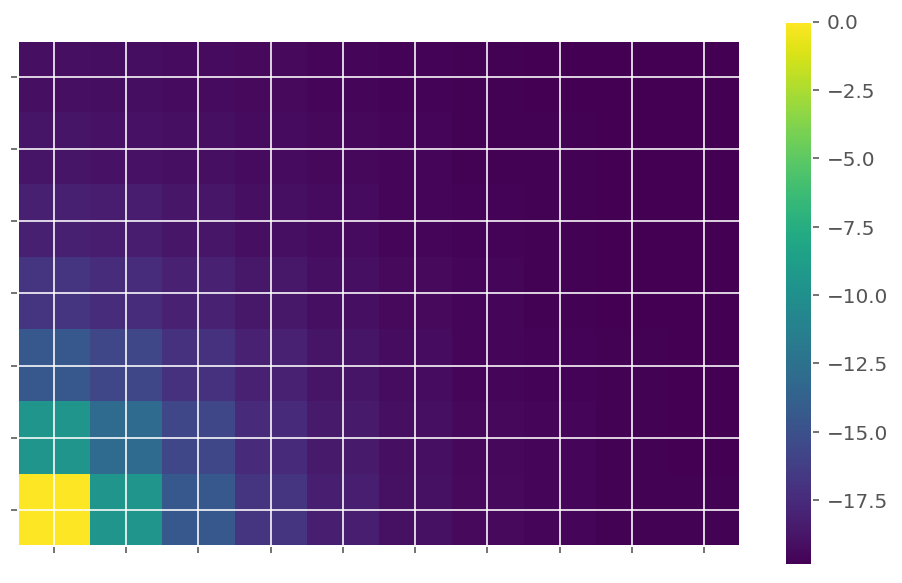

In [190]:
import rl.dp as dp
from tools.helpers import CountSlice, Progress

# set up a completely random policy
actions = list(world.stprobs.keys())
P = np.array([world.stprobs[action] for action in actions])
R = np.array([world.rewards[action] for action in actions])
policy = 1 / len(actions) * np.ones((len(actions), world.nr_states))

P_policy, R_policy = dp.mrp_from_mdp(P, R, policy)

value_function = dp.value_function(P_policy, R_policy, .95, thresh=1e-6)
value_function_exact = dp.value_function_exact(P_policy, R_policy, .95)
imshow_world(world, value_function)

difference = np.linalg.norm(value_function - value_function_exact, ord=np.inf)
print("Goodness of iterative algorithm:", difference)

### Policy iteration

Obtain optimal (deterministic) policy by alternating value function evaluation and using the greedy policy w.r.t. the last value function

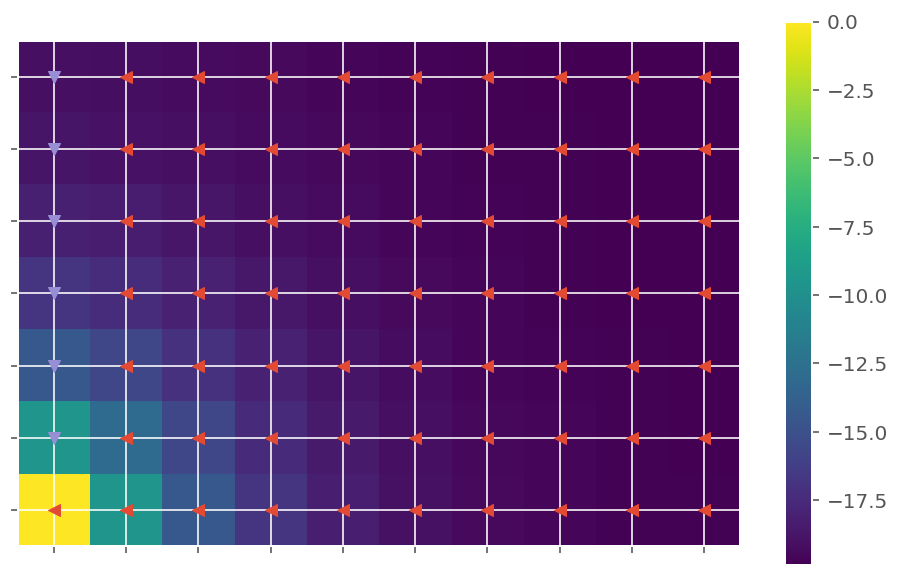

In [255]:
def visualize_policy(world, policy, value_function):
    markers = {'left': '<', 'up': '^', 'down': 'v', 'right': '>'}
    imshow_world(world, value_function)
    xs, ys = np.transpose([world._state_to_pos(state) for state in range(world.nr_states)])
    ys = world.gridsize[1] - ys - 1
    for action in range(len(actions)):
        sel = policy[action] > .5
        pl.scatter(xs[sel], ys[sel], marker=markers[actions[action]])

visualize_policy(world, policy, value_function)

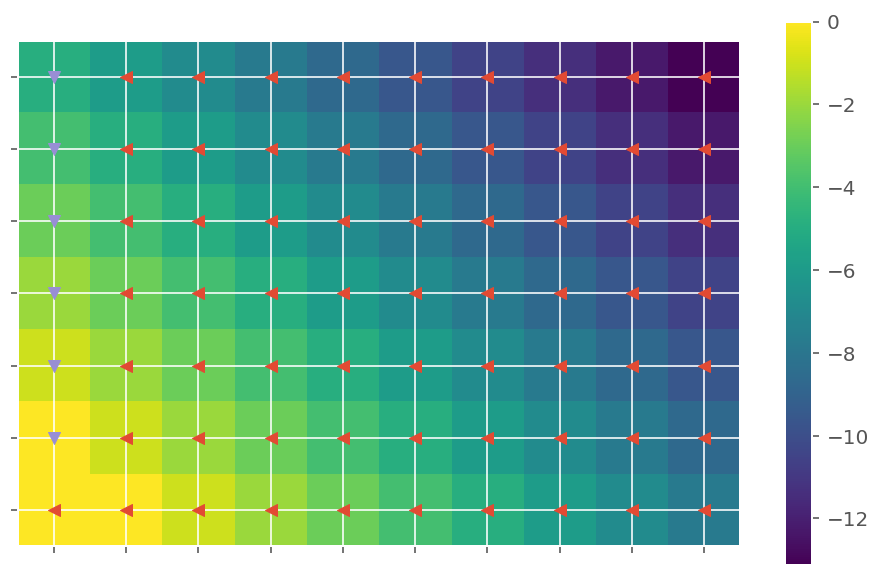

In [256]:
result = list(CountSlice(dp._optimal_policy_iterator(P, R, .99), 10))
visualize_policy(world, *result[-1])

### Optimal value iteration

Iterate Bellman eq. for optimal expected value 

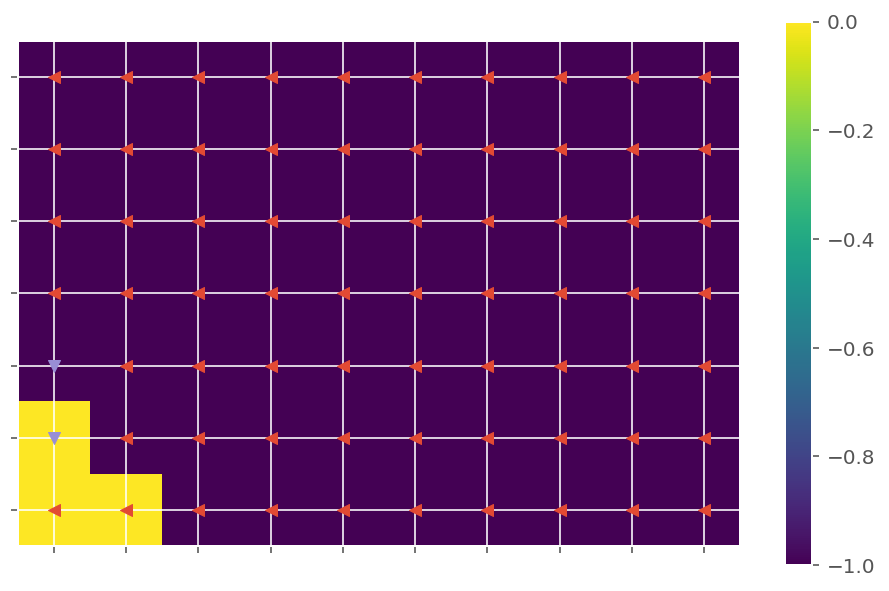

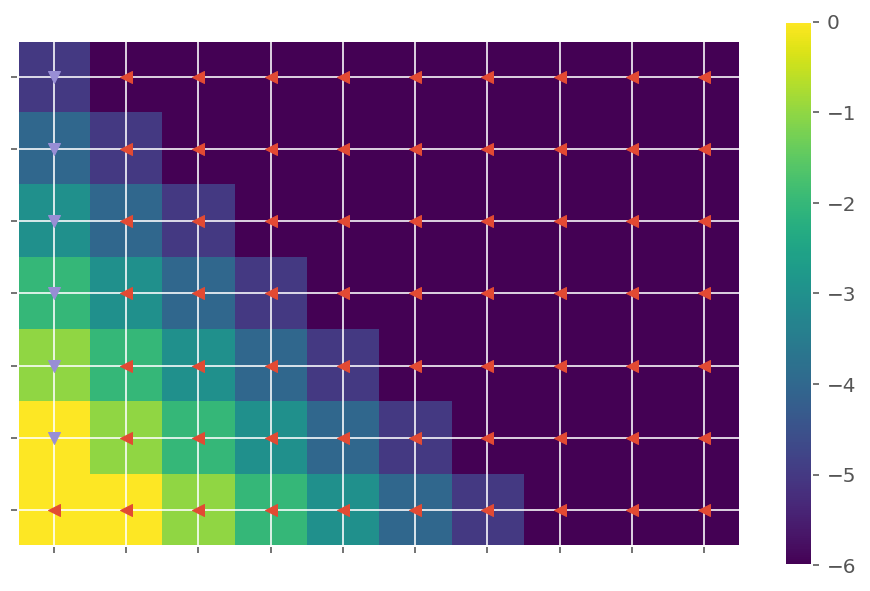

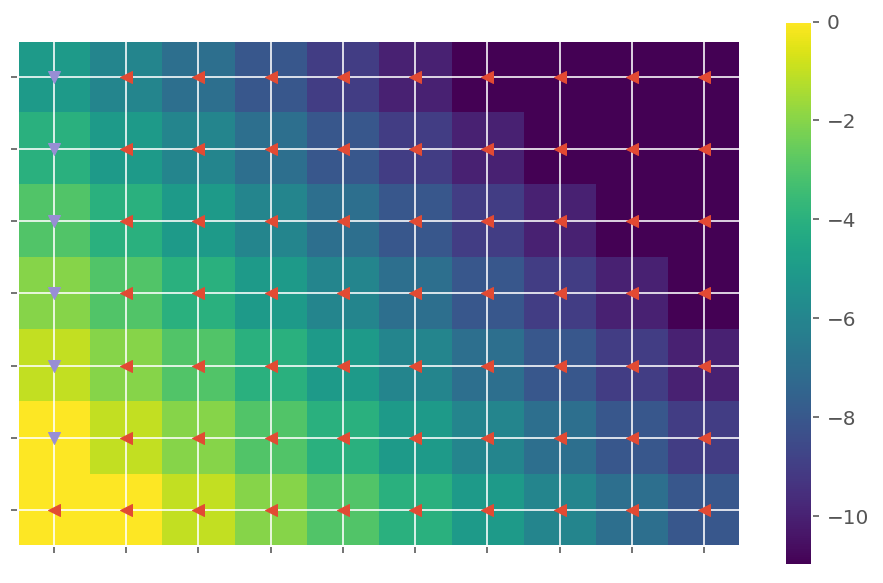

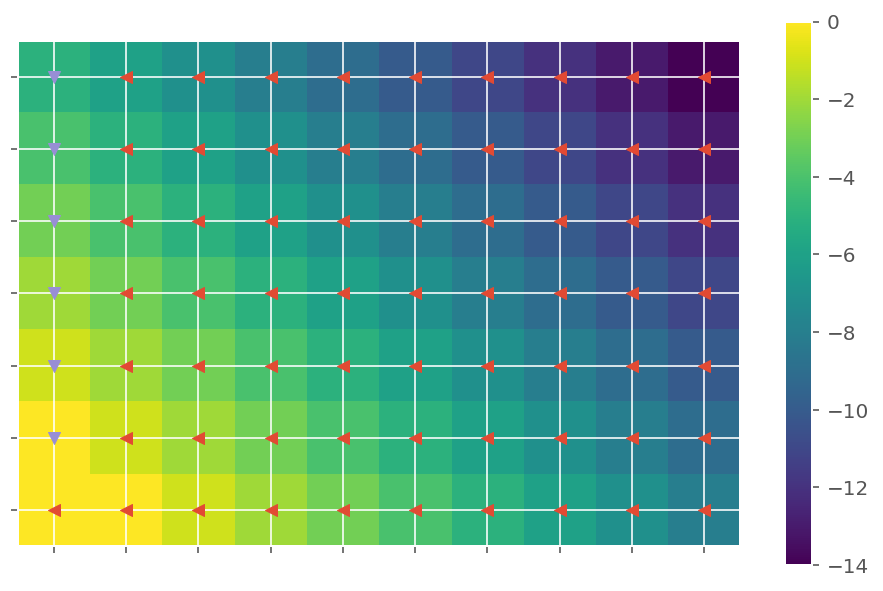

In [261]:
result = list(CountSlice(dp._optimal_value_iteration(P, R, .99), 20))[::5]

for vfun in result:
    policy = dp.greedy_policy(P, R, vfun)
    visualize_policy(world, policy, vfun)
    pl.show()